# Assignment 1 -- ML4F 2021

## Instructions
* This assignment covers the material discussed in Lectures ML1 and ML2. 
* Each group submits _only one_ notebook via canvas on the assignment page. 
* The notebook should be named `assignment1_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment1_group03.ipynb`.
* The notebook should run without raising any errors. 
* We recommend keeping the folder structure
```
assignment/
    data/
    lib/
    assignment1_groupXX.ipynb
```
* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. To see how to set up your own repo for your group, see `L2-git-slides.pdf`.
* Do not spend time on optimizing the speed of your code. However, if it runs for more than 5 minutes, we will terminate it.
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.

In [938]:
%reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from math import sqrt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Introduction

According to Wikipedia, the definition of a stock is: 
“Stock (also capital stock) is all of the shares into which ownership of a corporation is divided. In American English, the shares are collectively known as "stock". A single share of the stock represents fractional ownership of the corporation in proportion to the total number of shares.”
Some people trade with these stocks. But when is it worth to buy such one? What influence the prices of those stocks? In this assignment you will predict whether a stock is worth to buy or not. 
There are a lot of variables to choose from. The goal is to predict the column ‘class’. This is an indicator whether to buy the stock in the next period or not. 




Let's load and have a look at the data. We set the stock name as the index of the dataframe to provide a more structured view of the dataframe.

In [1252]:
path = os.path.join('data','stocks.xlsx')

df_data = pd.read_excel(path)
df_data = df_data.rename(columns={"Unnamed: 0": "Stock"})
df_data = df_data.set_index(['Stock'])

##### Interpretation of Dataframe
We see that the dataframe contains large, zero and NaN values. We decide to transform the variable Revenue Growth directly. We assume that all the variables in the dataframe should contain positive values. For example it is not possible to have negative Income Tax Expense, because in that case you woulde receive Tax. Therefore, the only variable that could be negative is the Revenue Growth. It could be a decrease of an increase in %. We add a constant to the Revenue Growth in order to make sure that every value is positive. If there are still negative values in the Revenue Growth, we consider them to be incorrect values, since it is not possible to have a decrease in Revenue that is bigger than 100%.

In [1253]:
df_data['Revenue Growth'] = df_data['Revenue Growth'] + 1

## Preparation

Before we start the analysis, we prepare the data by labelling them correctly and splitting into targets and features.

In [1254]:
target_name = 'Class'

# `sr_` prefix stands for a pandas Series
sr_targets = df_data.loc[:,target_name]

# The features are considered all the dataframe variables expect Class.
sr_features = df_data.iloc[:,:-1]

---

# Question 1
(30 points)


#### *As you learned in the lectures, preprocessing the data set is an important set to use machine learning models. Why is this important?*

#### Answer:
With pre-processing data we consider transforming the data to make it more useful for the model.

This so-called pre-processing input data is considered important, because the algorithms that we use in Machine Learning, like a (logistic) regression or Support Vector Machines, work better or faster when the considered features are on a similar scale and/or normally distributed. Since we are often using a lot of different features in our dataset, the features tend to have different sizes and scales. In order to run the algorithms in the proposed way, we should make sure that all these features have similar scales, to prevent one feature from significantly impacting the model because of its out of proportioned magnitude. 

If you would have a feature with values like 10 grams and a feature with values like 10 euro's, it will treat both features the same, eventhough the measure of both features are completely different. However, for the algorithm the numbers are just the same. 

It is also important because preprocessing is used to adress non-linearity or heterogeneity and it improves the numerical stability of the data. This can be done by normalization and standardization. normlaizing and standardizing makes sure that we can use the data in our estimations  and that we can assign the correct weights to the different parameters that will help us make a proper prediction.

#### *Use the methods discussed in ML2 to preprocess the data. Make descriptive statistics and histograms etc to find out more about the distributions of the data. Discuss your output: are there outliers etc? Then choose what preprocessing to apply.*


#### Answer:
First we checked the data using descriptive statistics and plots to determine the distributions.
#### Descriptive Statistics

In [945]:
df_data.describe()

Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
count  3.761000e+03    3.572000e+03     3.734000e+03  3.756000e+03   
mean   3.918622e+18   -2.819193e+03     3.700973e+09  2.188214e+09   
std    2.398954e+20    1.673319e+05     3.040688e+10  1.159028e+10   
min   -6.276160e+08   -1.000000e+07    -5.455740e+08 -1.105000e+09   
25%    5.793000e+07    9.976500e-01     3.135714e+06  3.092900e+07   
50%    4.385430e+08    1.061850e+00     1.414420e+08  1.908760e+08   
75%    2.395500e+09    1.188875e+00     1.199844e+09  8.922534e+08   
max    1.471205e+22    4.213966e+04     1.537249e+12  4.621600e+11   

       R&D Expenses  SG&A Expense  Operating Expenses  Operating Income  \
count  3.672000e+03  3.749000e+03        3.741000e+03      3.753000e+03   
mean   9.401830e+07  9.307406e+08       -5.999198e+26      6.748248e+08   
std    6.408912e+08  4.820928e+09        7.031507e+28      3.786291e+09   
min   -1.500000e+05  0.000000e+00       -3.948300e+30     -6.786000e+09   
25%    0.000000e+00  1.548900e+07        3.106600e+07     -1.308000e+06   
50%    0.000000e+00  7.381800e+07        1.386820e+08      4.104400e+07   
75%    9.911000e+06  3.510000e+08        5.885100e+08      2.712980e+08   
max    1.153700e+10  1.856830e+11        1.704000e+30      1.565540e+11   

       Interest Expense  Earnings before Tax  Income Tax Expense        Class  
count      3.745000e+03         3.728000e+03        3.742000e+03  3808.000000  
mean       1.002018e+08         5.725866e+08        1.762750e+08     0.429097  
std        6.991091e+08         2.793740e+09        1.011342e+09     0.495012  
min       -2.250000e+08        -8.878000e+09       -2.081114e+09     0.000000  
25%        0.000000e+00        -3.732902e+06        0.000000e+00     0.000000  
50%        2.563000e+06         2.842700e+07        5.335000e+06     0.000000  
75%        4.300000e+07         2.193835e+08        5.752550e+07     1.000000  
max        3.152300e+10         8.720500e+10        3.970800e+10     1.000000

First of all, the descriptive statistics show that every feature has multiple missing values, that we need to be aware of. The table also shows that various features have one or more negative values. We assume that these negative values represent incorrect values since it does not make sense to have negative Cost of Revenue for example. Furthermore, it shows that multiple features have a big difference between the minimum and maximum value, indicating possible outliers in the feature. We will not treat them right away, first we will plot the data. We also see that the average of class is <0.5, this shows us that there are more zeros in the dataset than there are ones. Meaning that the classifier is unbalanced .
#### Histograms
We cannot easily interpret the histograms without pre-processing the data. Right now the histograms are represented with one single large bar that includes more than 3500 observations. The reason for these distributions could be both the scale and the outliers of the features themselves. 
#### Histograms will be included later on, when they show up in a way that we can interpret them. 

#### Boxplots of the data
We create the following boxplots of every feature using the seaborn package in python. These boxplots show that every feature has one or more outliers, some with more extreme outliers than the others. This is just what we expected from the histogram.


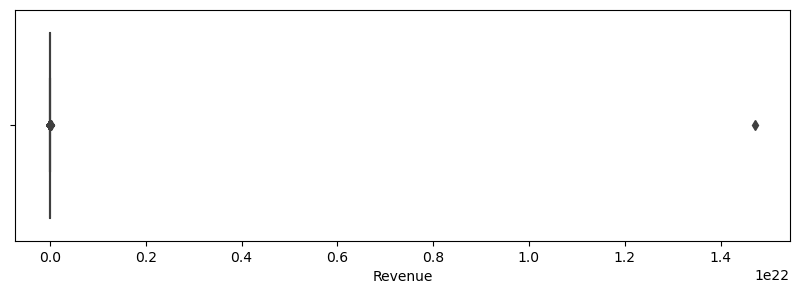

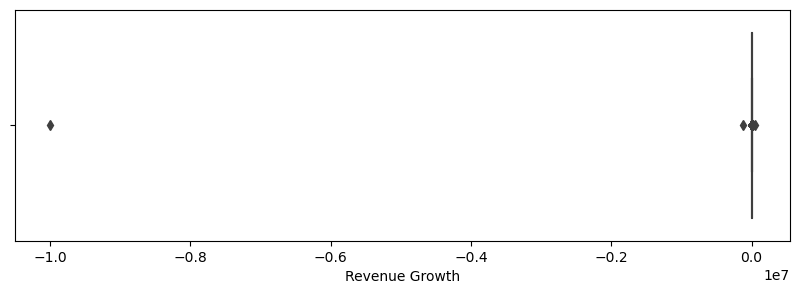

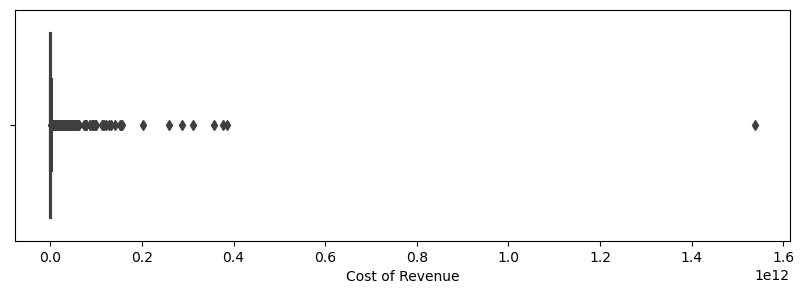

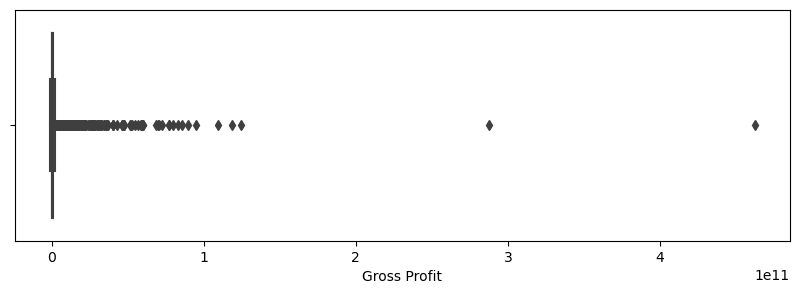

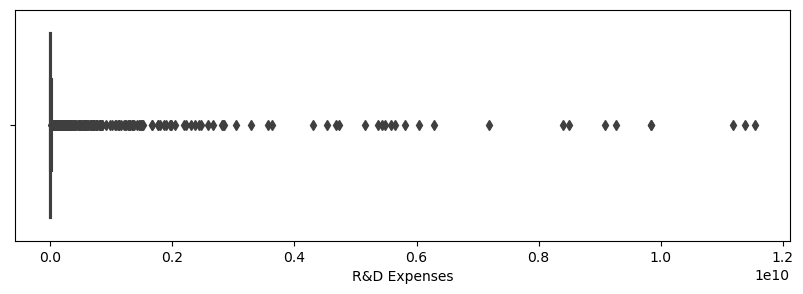

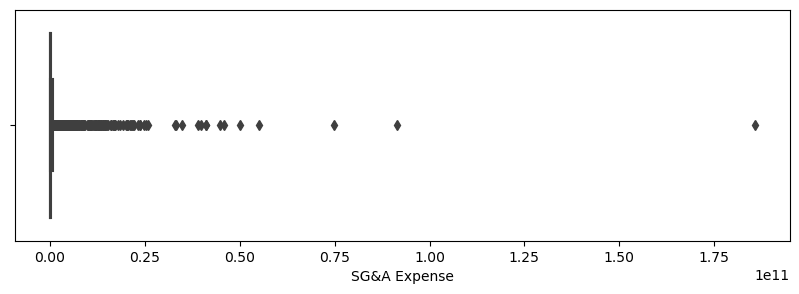

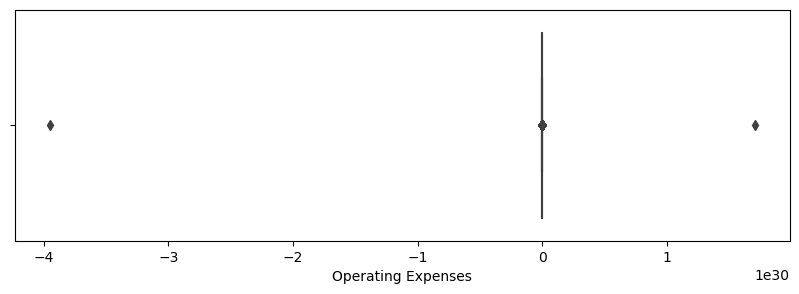

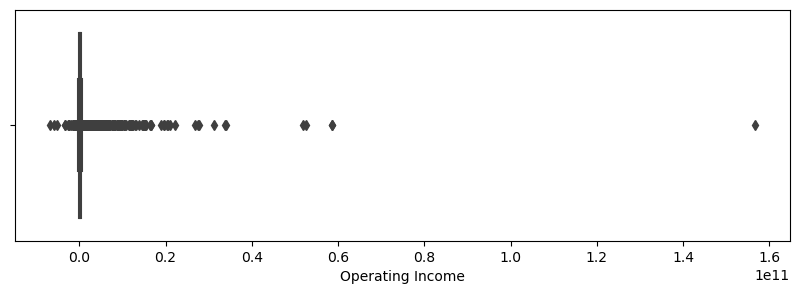

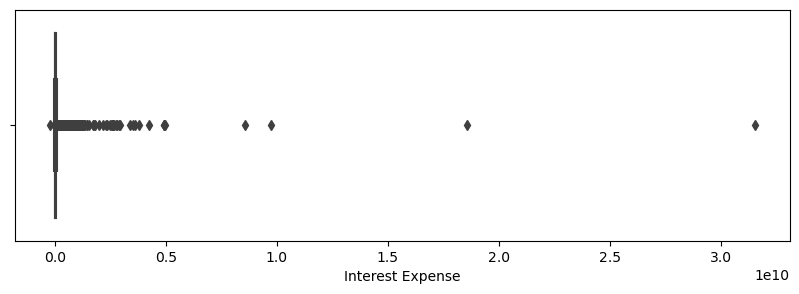

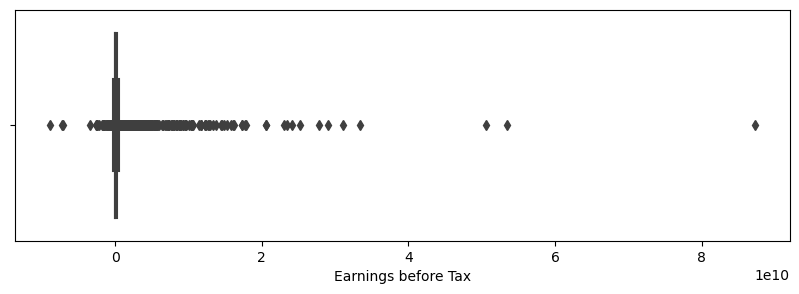

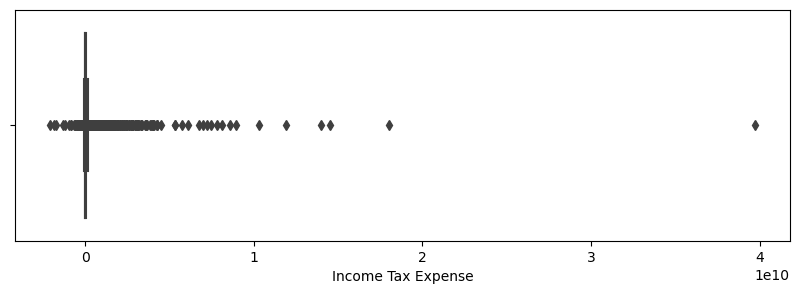

In [946]:
for columns in sr_features:
    fig, ax = plt.subplots()

    #Set the size of the plot
    fig.set_size_inches(10, 3)

    sns.boxplot(x=sr_features[columns])
    plt.show()

#### Transforming the features
In order to have usefull features for the analysis, we would need to pre-process the features. Our aim is to make the distributions of the features more similar to normal distributions.
1. First of all, we tried to clip the freatures by first removing the outliers at the 1 and 99 percentile. 
This turned out to be inefficient, resulting in similar distributions from before, with only the x-axis being slightly reduced to a smaller number.
2. Secondly, we tranformed every feature using a log tranformation.

#### Log Transformation
The log tranformation has three aspects of which we were interested in. 
1. The log transformation is a very usefull tranformation method on skewed data distritubtion. In our case, most of the features have positive skewness, looking at the earlier histograms or calculated with $Skewness = \frac{3* (Mean – Median)}{Standard Deviation}$
2. The log transformation decreases the scale of the distribution. Since we are working with very large numbers in the features, this aspect is very usefull for plotting the histograms. The distributions will become more normally distributed.
3. The log transformation automatically creates NaN/Missing values from the negative values in the features. It is not possible to take the logarithm of a negative value, therefore it will return NaN. In our case this is perfect, because we consider the negative values in the features to be incorrect. This is another reason why, earlier, we have changed the Revenue Growth feature that initially could be negative, into a feature that could only be positive. 

By taking the log of every feature, we had to determine what we want to do with all the zero's in the features. Some features have a lot of zero's in them, for example the feature: R&D Expenses. This means that around 2400 companies in the initial dataframe did not have any Research and Development Expenses. Taking the log of 0, will return infinite, meaning we had to come up with the value that we want to work with. 

We decided to let these zero's return to NaN, instead of zero, after the log tranformation. We have decided this, because it will create a more normally distributed feature and mainly because later on we want to predict the 'Class' with for example an increase/decrease in R&D Expenses. The latter would be biased if a lot of values in this feature are equal to zero, because it creates a big gap between the no  R&D expenses and some R&D expenses. However, we know that this will extract a lot of the companies in some features that have a large number of zero in it. ***We will address this issue and come up with a solution later in the assignment. ***

In [947]:
#Using numpy log to take the log of the whole dataframe, replacing the zero's/infinites by NaN
log_sr_features = (np.log(sr_features)).replace(-np.inf, np.nan)

#### Histograms
If we look again at the histograms of the features we see that features are way more normally distributed than before. However, we still acknowledge some outliers. These may not be similar to the incorrect values that we filtered out using the log transformation, but they could still mess up our predictions since they are extreme values that don't happen frequently. We don't want our algorithm to emphasis too much on these values, because this would mess up our predictions in the test set later on. Therefore, we decided to remove these outliers from the features using the Z-scores.
#### Robust Standardization
By standardizing every feature, every feature will have similar scales, making it easier to compare the features amongst each other. Furthermore, after the standardization we can easily remove a certain percentile of the data using the standard deviation that is calculated. We will use standardization to preprocess the features in the dataframe. We choose standardization over normalization, because standardization provides more usefull info about the outliers in the dataframe, which is asked in the question.
 
In our case we use the RobustScaler of scikit, since it is more robust against outliers compared to the StandardScaler, meaning it scales the features according to the InterQuartileRange (0.25|0.75) of that feature. 

However, since this method is not immune to outliers, we still find some outliers in the histograms after the standardization. We clip these outliers ourselves using 4 standard deviations relative to every feature. Meaning we replace all the values that are outside 0.1% and 99.99% of the distribution of a certain feature by NaN. 
#### Toevoegen: This last part is also an assumption in logistic regression models.

In [622]:
# from sklearn.preprocessing import Normalizer
# log_sr_features2 = (np.log(sr_features)).replace(-np.inf, 0)
# log_sr_features2 = log_sr_features2.fillna(log_sr_features2.mean())
# df_robust_nrm = log_sr_features2.copy()
# df_robust_nrm[df_robust_nrm.columns] = Normalizer().fit_transform(df_robust_nrm[df_robust_nrm.columns])

In [948]:
df_robust_std = log_sr_features.copy()
df_robust_std[df_robust_std.columns] = RobustScaler().fit_transform(df_robust_std[df_robust_std.columns])

df_robust_std[df_robust_std < -4] = np.nan
df_robust_std[df_robust_std > 4] = np.nan

### Histogram, Titels en assie aanpassen. Conclusion of the data processing.

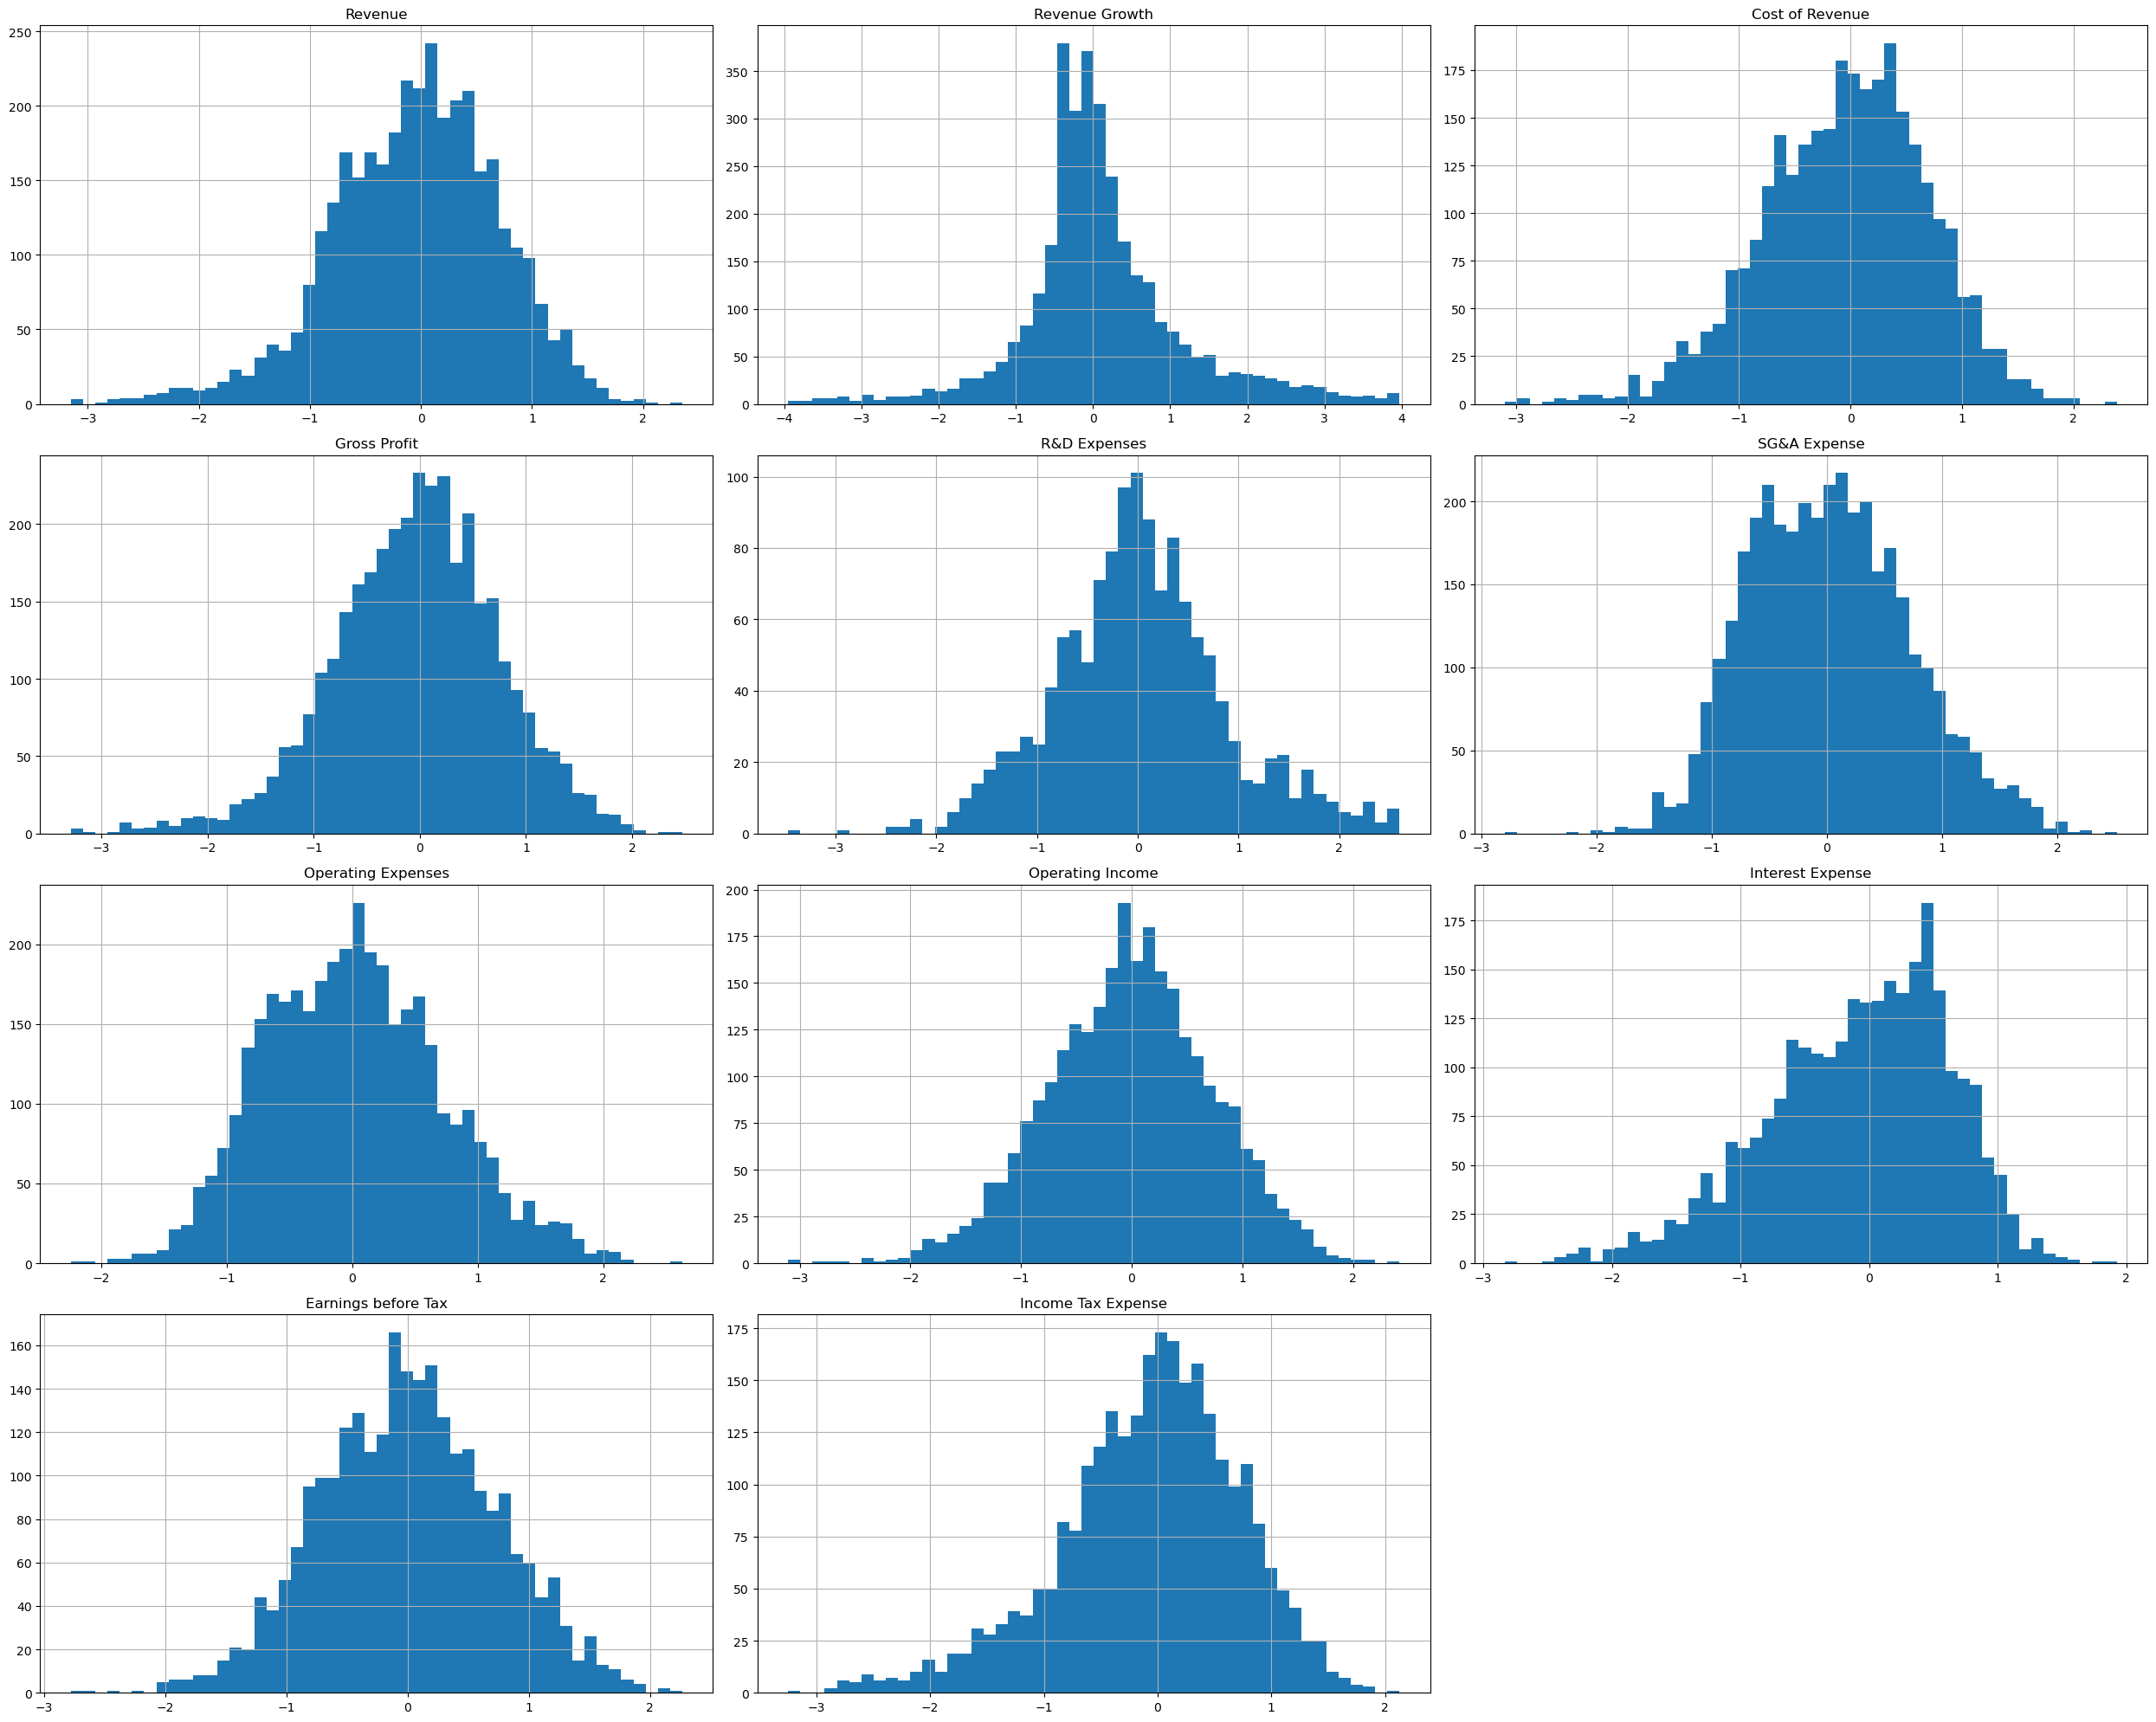

In [949]:
df_robust_std.hist(bins=50, figsize=(25, 20))
plt.tight_layout()    
plt.show()

When we look at the histograms above we see that our efforts resulted in Standard distributed data. This will be most usefull for when we run the logit regression later on in the assignment. 

#### *Which features will you use to make your predictions? Looking at a correlation matrix might help: df_date.corr gives a correlation matrix of the dataframe. Other feature selection approaches are also fine. Explain your choices.*

#### Features Selection Method 1:
In order to determine which features we would like to select to make predictions later on, we create a heatmap using the seaborn package with a correlation matrix of all the features in the dataframe. Afterwards, we determine the two features with the highest correlation with the target 'Class'.

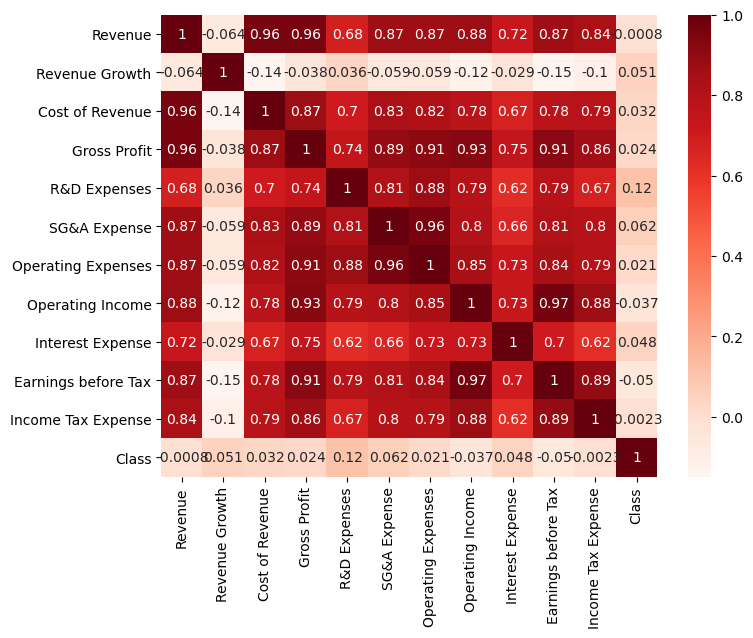

In [950]:
df_robust_std['Class'] = sr_targets
plt.figure(figsize=(8,6))
cor = df_robust_std.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [951]:
cor_target = abs(cor["Class"])
relevant_features = cor_target[cor_target>0.05]
relevant_features.sort_values(ascending =False)

Class             1.000000
R&D Expenses      0.115930
SG&A Expense      0.061567
Revenue Growth    0.051008
Name: Class, dtype: float64

Here, we see that the features R&D Expenses and SG&A Expense have the highest correlation with the target. This would suggest that we would take these features into consideration with our logistic regression. However, an assumption of the logistic regression model is that there is absence of multicollinearity. Meaning that the explanatory variables, in this case the features R&D Expenses and SG&A Expense should not be correlated with each other. Looking at the heat map, we clearly see a high correlation (0.96) between the two features, indicating that we should not use them both in the logistic regression. However this is not a problem for us since multicollinearity affects the standard errors but does not change the coefficients. Revenue Growth would be a much better second feature in the logistic regression as it is almost as correlated with the target as SG&A Expense, however it has a low correlation with Operating Expenses. 

#### Feature Selection Method 2:
Using Variance Threshold to determine what feature is the most appropriate for predictions over the target. If features don't really change in their values, it means they have a low variance, but also that it unlikely that they hold good predictions over the target, since they don't change that much. For this we need to determine what the variance threshold will be for the data. Looking at the data, we already see that all the features have similar variances. Some are much higher than others, like Revenue Growth and R&D Expenses, which could therefore be more predictive over the target. This is in line with the correlation matrix in method 1.

In [952]:
df_robust_std.iloc[:,:-1].var()

Revenue                0.562405
Revenue Growth         1.129307
Cost of Revenue        0.551100
Gross Profit           0.609348
R&D Expenses           0.746184
SG&A Expense           0.484388
Operating Expenses     0.502416
Operating Income       0.549864
Interest Expense       0.496701
Earnings before Tax    0.527100
Income Tax Expense     0.640200
dtype: float64

In [953]:
robust_sel = VarianceThreshold(threshold = (0.5)).fit_transform(df_robust_std.iloc[:,:-1])
pd.DataFrame(robust_sel) #This excludes the two features SG&A expenses and Interest Expenses from the dataframe

0         1         2         3         4         5         6  \
0     1.432433 -0.771616  1.336571  1.639212       NaN  1.721876  1.607767   
1     0.571032       NaN  0.581864  0.457784  0.648968  0.593769  0.051539   
2     1.512850 -0.245626  1.535559  1.457982       NaN  1.652297  1.060803   
3     1.124444 -0.318519  1.117913  1.128098       NaN  1.317708  0.622163   
4     1.022416 -0.305454  0.987260  1.082805       NaN  1.092702  1.088263   
...        ...       ...       ...       ...       ...       ...       ...   
3803 -0.673499  0.210677 -0.627778 -1.074145       NaN -0.968679 -2.828825   
3804 -0.348329 -0.963158 -0.847403 -0.170332 -0.293421 -0.063590 -0.627081   
3805 -0.720977       NaN -0.749283 -0.881217       NaN -0.764249       NaN   
3806 -0.118244  0.372188 -0.044159 -0.717898       NaN -0.731368 -0.883382   
3807 -0.732606  0.657738 -0.817345 -0.803749 -0.798089 -0.779057 -1.075579   

             7         8  
0     1.668037  1.385833  
1     0.191986  0.181989  
2     1.048144  1.010401  
3     0.310806 -0.914447  
4     1.107098  1.056066  
...        ...       ...  
3803       NaN -1.999745  
3804 -0.571067 -0.409321  
3805       NaN       NaN  
3806 -0.810099 -0.544058  
3807 -1.026209 -0.635707  

[3808 rows x 9 columns]

From the table we can conclude that SG&A and Interest Expenses will not be used as features

#### *Why should you make a training and a test set?* 

#### Answer:
A training set is used to train the model that we are going to specify. We want make a model that uses the features in the dataframe to explain the target in the dataframe. Using the training set, we determine what model we use that explains the values of the target with the most precision. When the model is trained, we are going to test that model on the test set, to check whether the model that we created on the training set will also provide good predictions of the target if it receive completely new input values. The model will be robust if it performs well in both the training and the test set. However, if it only performs well in the training set but not on the test set, then it might be the case that it looked at very specific/extreme values in the training set and used those values to predict the target. However, if these values are not that specific or extreme in the test set, it will be hard for the model to predict the target. 


#### *Make a training and test set. Describe briefly what parameters these sets have: how many observations in both sets?*

We will work with two seperate dataframes.
1. A DataFrame that contains only the target values of every company. 
2. A DataFrame that contains two features, R&D Expenses and Revenue Growth, that were selected based on their correlation with the target and each other. Since the feature R&D Expenses, initially contained a lot of zero expenses, the missing values in this feature are dropped from the dataframe.

For splitting the dataset in a training and test set, we use the 80/20 rule. This means we select 80% of our dataframe for training the model and 20% of our dataframe for testing the model. We chose this ratio over the 70/30 ratio since that one is more usefull for gigantic datasets, which ours is not. 

In [1442]:
sr_rbst_features = df_robust_std[['R&D Expenses','Revenue Growth','Class']] #SGA?
sr_rbst_features = sr_rbst_features.dropna()
sr_rbst_targets = sr_rbst_features['Class']
sr_rbst_features = sr_rbst_features.iloc[:,:-1]


In [1443]:
features_train,features_test,targets_train,targets_test=train_test_split(sr_rbst_features,sr_rbst_targets,test_size=0.2)

# Question 2
(10 points)

#### *Estimate a Logistic regression model with the target variable 'class'. Use the User Guide of Scikit-learn for the syntax and the training set of the previous question. What are the estimated coefficients?*

We use a logistic regression using the liblinear solver since it is considered a good solver for small datasets and since this dataset contains only thousands of companies, it is considered a small dataset. Using the LibLinear solver, we are able to perform two penalty methods. L1 regularization is called Lasso and L2 regularization is called Ridge Regression. The former is often used when , both are used in order to prevent overfitting of the model. Since Ridge Regression is not able to zero out coefficients, we are using Lasso as regularization method. We don't exactly know which of the features are important for predicting the target, therefore by using a Ridge Regression we would have to use them all, or use none of them in the model. 

it is also possible to select the features before hand. In that case the Ridge Regression could be a good penalty method. We preselected our features so we run the L2 penalty. 

In [1444]:
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error

#### Method 1: Using two features, with deleted values

In [1445]:
# clf = LogisticRegression(penalty='l1', solver='liblinear').fit(features_train, targets_train)
# targets_pred = clf.predict(features_test)
# print('RMSE: ' + str(round(sqrt(mean_squared_error(targets_test,targets_pred)),2)))
# print('R_squared: ' + str(round(r2_score(targets_test,targets_pred),2)))
# print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
# print('ROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))

Logistic Regression - Ridge Regression Regularization

In [1446]:
clf = LogisticRegression(penalty='l2', solver='liblinear').fit(features_train, targets_train)
targets_pred = clf.predict(features_test)
print('RMSE: ' + str(round(sqrt(mean_squared_error(targets_test,targets_pred)),2)))
print('R_squared: ' + str(round(r2_score(targets_test,targets_pred),2)))
print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
print('ROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))
print(clf.coef_, clf.intercept_)

RMSE: 0.62
R_squared: -0.59
Accuracy of the model: 0.6174
ROC: 0.5344
[[0.23258131 0.15781215]] [-0.48058907]


#### Interpretation of the coefficients

#### Method 2: Using two features, with NaN values = mean

In [994]:
# sr_rbst_features = df_robust_std[['R&D Expenses','Revenue Growth','Class']]
# sr_rbst_features = sr_rbst_features.fillna(sr_rbst_features.mean())
# sr_rbst_targets = sr_rbst_features['Class']
# sr_rbst_features = sr_rbst_features.iloc[:,:-1]
# features_train,features_test,targets_train,targets_test=train_test_split(sr_rbst_features,sr_rbst_targets,test_size=0.3)
# clf = LogisticRegression(penalty='l1', solver='liblinear').fit(features_train, targets_train)
# targets_pred = clf.predict(features_test)
# print('RMSE: ' + str(round(sqrt(mean_squared_error(targets_test,targets_pred)),2)))
# print('R_squared: ' + str(round(r2_score(targets_test,targets_pred),2)))
# print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
# print('ROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))


#### Method 3: Using all features, with deleted values

In [995]:
# sr_rbst_features = df_robust_std.copy()
# sr_rbst_features = sr_rbst_features.dropna()
# sr_rbst_targets = sr_rbst_features['Class']
# sr_rbst_features = sr_rbst_features.iloc[:,:-1]
# features_train,features_test,targets_train,targets_test=train_test_split(sr_rbst_features,sr_rbst_targets,test_size=0.3)
# clf = LogisticRegression(penalty='l1', solver='liblinear').fit(features_train, targets_train)
# targets_pred = clf.predict(features_test)
# print('RMSE: ' + str(round(sqrt(mean_squared_error(targets_test,targets_pred)),2)))
# print('R_squared: ' + str(round(r2_score(targets_test,targets_pred),2)))
# print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
# print('ROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))


#### Method 4: Using all features, with NaN values = mean

In [996]:
# sr_rbst_features = df_robust_std.copy()
# sr_rbst_features = sr_rbst_features.fillna(sr_rbst_features.mean())
# sr_rbst_targets = sr_rbst_features['Class']
# sr_rbst_features = sr_rbst_features.iloc[:,:-1]
# features_train,features_test,targets_train,targets_test=train_test_split(sr_rbst_features,sr_rbst_targets,test_size=0.3)
# clf = LogisticRegression(penalty='l1', solver='liblinear').fit(features_train, targets_train)
# targets_pred = clf.predict(features_test)
# print('RMSE: ' + str(round(sqrt(mean_squared_error(targets_test,targets_pred)),2)))
# print('R_squared: ' + str(round(r2_score(targets_test,targets_pred),2)))
# print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
# print('ROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))


---

# Question 3
(30 points)

#### *Make predictions for the test set.*

In [1416]:
targets_pred = clf.predict(features_test)
print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
print('AUROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))

Accuracy of the model: 0.6478
AUROC: 0.533


#### *Discuss the results in terms of investment advice: would you put your money on your algorithm?*

#### Answer:
Also looking at the AUROC, we see that the area under the roc curve is 0.53. This is only 0.03 better than randomly guess what the outcome would be. Therefore, the algorithm hasn't a strong prediction. 

#### *Feature engineering can also be helpful to make better predictions. Define at least 2 new features with the features given in the dataset.* 


With Feature Engineering we make adjustments like combinations to the features and categorize them as new features to increase the predictability of the features in the model.
We are introducing the following new features into our dataframe:
1. Dummy variables for the values that we have assumed to be zero. Earlier, we decided to drop the values of for example R&D Expenses, if a company had no R&D Expenses. Therefore, untill now we only worked with companies that had R&D Expenses. These dummy variables will now be included into the dataframe and are zero if the company has no R&D expenses and 1 if the company has R&D Expenses. Same goes for Interest Expense, Income Tax Expense and Cost of Revenue.
2. Net and Gross Profit Margin. Including a profitability ratio for every company by dividing the Profit After Tax by the Total Revenue.
3. Filling the missing values with the mean of the the feature corresponding feature. 

In [1314]:
sr_features['R&D_Dummy'] = (sr_features['R&D Expenses'] > 0).astype(int)
sr_features['Interest_Dummy'] = (sr_features['Interest Expense'] > 0).astype(int)
sr_features['Tax_Dummy'] = (sr_features['Income Tax Expense'] > 0).astype(int)
sr_features['Cost_Revenue_Dummy'] = (sr_features['Cost of Revenue'] > 0).astype(int)
sr_features['Net_Profit_Margin'] = (sr_features['Earnings before Tax'] - sr_features['Income Tax Expense'])/sr_features['Revenue']
sr_features['Gross_Profit_Margin'] = (sr_features['Revenue'] - sr_features['Cost of Revenue'])/sr_features['Revenue']


Use the new features and rerun the classification. Does the new features improve the predictions? Is it possible that it does worse? Please explain.

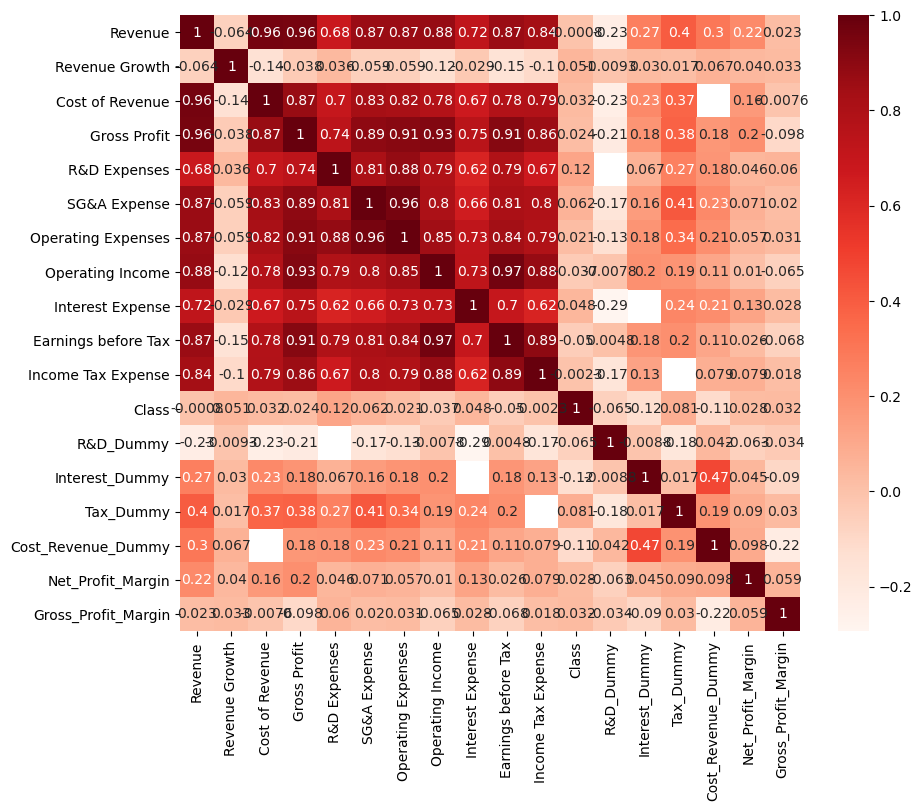

In [1315]:
sr_rbst_features_dum = df_robust_std.join(sr_features.iloc[:,11:])

sr_rbst_features_dum['Class'] = sr_targets
plt.figure(figsize=(10,8))
cor = sr_rbst_features_dum.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [1359]:
cor_target = abs(cor["Class"])
relevant_features = cor_target[cor_target>0.05]
relevant_features.sort_values(ascending =False)

Class                 1.000000
Interest_Dummy        0.123048
R&D Expenses          0.115930
Cost_Revenue_Dummy    0.111171
Tax_Dummy             0.081179
R&D_Dummy             0.064861
SG&A Expense          0.061567
Revenue Growth        0.051008
Name: Class, dtype: float64

Filling with mean or drop nan - Keeping only relevant features

In [1407]:
sr_rbst_features = sr_rbst_features_dum[relevant_features.index]
#sr_rbst_features = sr_rbst_features.drop(['Gross_Profit_Margin'], axis=1)
#sr_rbst_features = sr_rbst_features.drop(['Net_Profit_Margin'], axis=1)

#Feature Selection method 3: filling in the mean for NaN
sr_rbst_features = sr_rbst_features.fillna(sr_rbst_features.mean())


sr_rbst_features = sr_rbst_features.dropna()
sr_rbst_targets = sr_rbst_features['Class']
sr_rbst_features = sr_rbst_features.drop(['Class'], axis=1)
features_train,features_test,targets_train,targets_test=train_test_split(sr_rbst_features,sr_rbst_targets,test_size=0.3)
clf = LogisticRegression(penalty='l1', solver='liblinear').fit(features_train, targets_train)
targets_pred = clf.predict(features_test)
print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
print('ROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))


Accuracy of the model: 0.6142
ROC: 0.5717


#### Answer:
By feature engineering, we are able to improve the AUROC from approximately 0.55 to 0.57. It is a minor improvement, still it is an improvement. This would make it slightly more trustworhty when one wants to put his/hers money behind this algorithm.  

# Question 4
(10 points)

#### *Run the same model as in the previous question but set the tolerance for stopping criteria on 0.01 instead of the default one of 1e-4. Discuss these results in relation to the default: what is different? Why?*

This tells scikit to stop searching for a minimum (or maximum) once some tolerance is achieved, i.e. once you're close enough.

In [1408]:
clf = LogisticRegression(penalty='l2', solver='liblinear', tol=0.01).fit(features_train, targets_train)
targets_pred = clf.predict(features_test)
print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
print('AUROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))

Accuracy of the model: 0.615
ROC: 0.573


In [1409]:
clf = LogisticRegression(solver='liblinear', penalty='l2').fit(features_train, targets_train)
targets_pred = clf.predict(features_test)
print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),4)))
print('AUROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))

Accuracy of the model: 0.6142
ROC: 0.5719


Using the solver with tolerance of 0.01, it will find different AUROC/accuracies. Meaning it finds different coefficients, every time it runs. Using the default method, it results in the same AUROC/Accuracy every time it runs. This isn't surprising because it is the threshold for when the solver should stop searching for the maximum likelihood. Meaning that if we set this threshold higher, the solver will finish more quickly, because it stops earlier with searching for the maximum likelihood. However, it could also find a different maximum likelihood every time it runs. 

# Question 5
(20 points)

#### *Compute the confusion matrix of the model estimated in Question 4.* 
#### *Compute precision and recall for this case.*

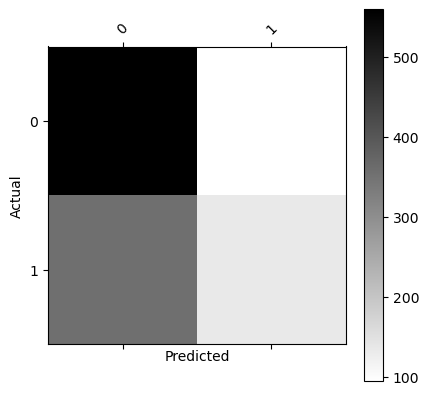

Predicted    0    1
Actual             
0          559   94
1          356  134


              precision    recall  f1-score   support

           0       0.61      0.86      0.71       653
           1       0.59      0.27      0.37       490

    accuracy                           0.61      1143
   macro avg       0.60      0.56      0.54      1143
weighted avg       0.60      0.61      0.57      1143



In [1243]:
df_confusion = pd.crosstab(targets_test, targets_pred, rownames=['Actual'], colnames=['Predicted'])
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()

plot_confusion_matrix(df_confusion)
print(df_confusion)
print('\n')
print(classification_report(targets_test, targets_pred))

#### *Interpret the confusion matrix. Pay attention to whether your dataset is balanced and the costs of various outcomes (e.g. FP, TP etc.).*

When we first look at the confusion matrix we see that the model predicts more false negatives than false positives. 

This is inline with the precision, which is lower for not to buy (class 0) and higher for buying (class 1). Meaning the algorithm is better in creating more relevant predictions for class 1 compared to class 0. 
### ?

The recall is much higher for no to buy (class 0) compared to buying (class 1). This means that the algorithm better classifies that you shouldn't buy in comparison to that you should buy the stock. 

Here we see that the dataset is not that balanced as there are much more stocks that you shouldn't buy compared to stocks that you should buy. Therefore, the interpretation .....
Furthermore, we see that the algorithm predicts relatively more False Positives compared to False Negatives. Meaning it predicts relatively more times that you should buy, when infact you should not buy compared to the relative times that it predicts that you should not buy, when infact you should buy. Thus letting the algorithm trade would result in a more defensive investment strategy, resulting in a less risky trading algorithm. 

---